# Goal: estimate expected lifetime of a customer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error,mean_absolute_error,mean_squared_error,r2_score
from scipy.stats import loguniform,uniform

In [49]:
data = pd.read_csv(r'C:\Users\Paras\Desktop\parasonly\ML Projects\data\CustomerChurn.csv')
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [51]:
# converting the TotalCharges from categorical to numerical
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')

# Convert the SeniorCitizen column to categorical
data['SeniorCitizen'] = data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

In [52]:
# Dropping null values
data = data.dropna()

In [53]:
# Adding a feature to know whether the customer's contract is long term or short term 
data['IsLongTermContract'] = data['Contract'].apply(lambda x: 'Yes' if x == 'Two year' or x == 'One year' else "No")

In [54]:
# Adding a feature to Service Density to know how many serviced does the customer have

service_columns = [
    'PhoneService', 'MultipleLines', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies'
]

# We use .eq('Yes') to get True/False, then sum horizontally (axis=1)
data['ServiceDensity'] = data[service_columns].eq('Yes').sum(axis=1)

# If you consider 'InternetService' as a service, add 1 if it is not 'No'
data['ServiceDensity'] += (data['InternetService'] != 'No').astype(int)

# Verify the new feature
data[['customerID', 'ServiceDensity']].head(5)

,customerID,ServiceDensity
0,7590-VHVEG,2
1,5575-GNVDE,4
2,3668-QPYBK,4
3,7795-CFOCW,4
4,9237-HQITU,2


In [55]:
data.info()

<class 'pandas.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7032 non-null   str    
 1   gender              7032 non-null   str    
 2   SeniorCitizen       7032 non-null   object 
 3   Partner             7032 non-null   str    
 4   Dependents          7032 non-null   str    
 5   tenure              7032 non-null   int64  
 6   PhoneService        7032 non-null   str    
 7   MultipleLines       7032 non-null   str    
 8   InternetService     7032 non-null   str    
 9   OnlineSecurity      7032 non-null   str    
 10  OnlineBackup        7032 non-null   str    
 11  DeviceProtection    7032 non-null   str    
 12  TechSupport         7032 non-null   str    
 13  StreamingTV         7032 non-null   str    
 14  StreamingMovies     7032 non-null   str    
 15  Contract            7032 non-null   str    
 16  PaperlessBilling    70

Text(0.5, 1.0, 'Correlation Heatmap')

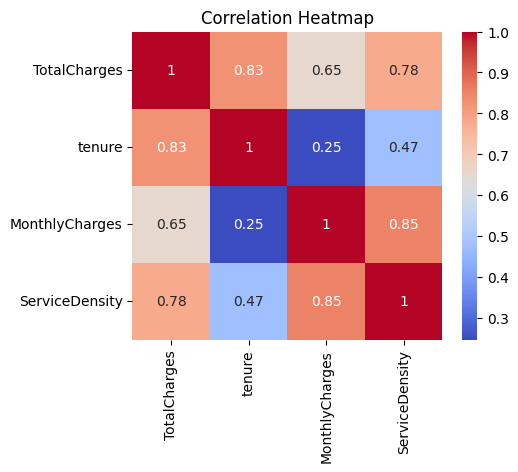

In [57]:
corr = data[['TotalCharges','tenure','MonthlyCharges','ServiceDensity']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#### As we can see there is high correlation between TotalChargers and tenure, so to avoid overfitting we will drop TotalChargers column from X variables

In [58]:
# Separating the X_variables and y_variable
X= data.drop(['tenure','customerID','TotalCharges'],axis=1).copy()
y = data['tenure'].values

In [59]:
X.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,IsLongTermContract,ServiceDensity
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No,No,2
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No,Yes,4
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,No,4
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No,Yes,4
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,No,2


In [60]:
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = [col for col in X.columns if col not in numeric_features]

In [61]:
categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'IsLongTermContract']

In [64]:
# Feature Scaling
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])

# Encoding for categorical columns
categorical_transformer = Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=True))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',categorical_transformer,categorical_features)],
    remainder='drop')

In [65]:
# Splitting the data into Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
# Define the cross-validation strategy (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [67]:
len(X_train), len(X_test)

(5274, 1758)

In [68]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'Churn', 'IsLongTermContract', 'ServiceDensity'],
      dtype='str')

## Building baseline models 

### 1. Linear Regression

In [69]:
linear_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',LinearRegression())
])

cv_scores = cross_val_score(
    linear_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

cv_mean = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"Linear Regression CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")

Linear Regression CV MAE: 11.3726 ± 0.2968


### 2. ElasticNet

In [70]:
elastic_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',ElasticNet())
])

cv_scores = cross_val_score(
    elastic_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

cv_mean = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"Elastic CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")

Elastic CV MAE: 13.8666 ± 0.1982


### 3. Random Forest Regressor

In [71]:
rfr_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',RandomForestRegressor())
])

cv_scores = cross_val_score(
    rfr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

cv_mean = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"Random Forest CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")

Random Forest CV MAE: 11.7191 ± 0.2674


### 4. XGBoost

In [72]:
xgb_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',XGBRegressor())
])

cv_scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

cv_mean = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"XGBoost Regression CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")

XGBoost Regression CV MAE: 11.9674 ± 0.2406


## Calculating cv results for each model 

In [73]:
pipelines = {'LinearRegression':linear_pipeline,
             'ElasticNet':elastic_pipeline,
             'RandomForest':rfr_pipeline,
             'XGBoost':xgb_pipeline}

cv_results = []

for model_name, pipeline in pipelines.items():
    
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_mean_absolute_error"
    )
    
    cv_results.append({
        "Model": model_name,
        "CV MAE Mean": -scores.mean(),
        "CV MAE Std": scores.std()
    })

In [74]:
cv_results_df = pd.DataFrame(cv_results)

cv_results_df = cv_results_df.sort_values(
    by="CV MAE Mean"
)

cv_results_df

,Model,CV MAE Mean,CV MAE Std
0,LinearRegression,11.372598,0.296788
2,RandomForest,11.696533,0.295800
3,XGBoost,11.967445,0.240581
1,ElasticNet,13.866588,0.198165


In [ ]:
best_model_name = cv_results_df.iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]

print("Selected model based on CV:", best_model_name)

Selected model based on CV: LinearRegression


In [ ]:
best_pipeline.fit(X_train, y_train)

y_test_pred = best_pipeline.predict(X_test)

print("Final Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Final Test MSE:" , mean_squared_error(y_test,y_test_pred))
print("Final Test RMSE:", root_mean_squared_error(y_test, y_test_pred))
print("Final Test R2:", r2_score(y_test, y_test_pred))


Final Test MAE: 11.118856017769245
Final Test MSE: 206.38900418438536
Final Test RMSE: 14.366245305729167
Final Test R2: 0.6559084665150863


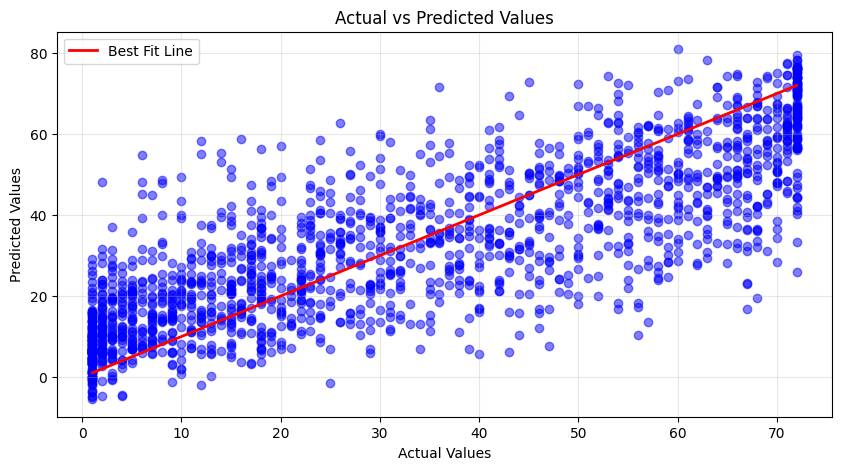

In [82]:
# Plotting of y_test and y_pred

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', lw=2, label='Best Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Residual Analysis

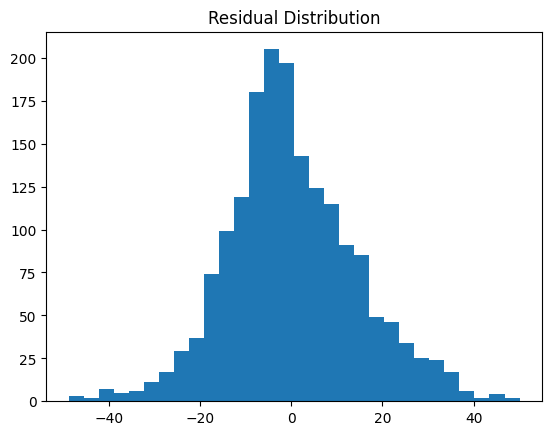

In [86]:
residuals = y_test - y_test_pred
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()


## HyperParameter Tuning - RandomizedSearch CV

#### 1. ElasticNet HPO

In [ ]:
elastic_param_grid = {
    'model__alpha': loguniform(1e-4, 1e2),  # Samples between 0.0001 and 100
    'model__l1_ratio': uniform(0, 1),       # 0 is Ridge, 1 is Lasso
    'model__max_iter': [1000, 2000, 5000]
}

elastic_search = RandomizedSearchCV(
    elastic_pipeline, elastic_param_grid,
    n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    random_state=42, verbose=2
)

elastic_search.fit(X_train, y_train)

print(f"Best CV MAE: {-elastic_search.best_score_:.4f}")
print(f"Best params: {elastic_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV MAE: 11.3553
Best params: {'model__alpha': np.float64(0.00021800651586435218), 'model__l1_ratio': np.float64(0.7219987722668247), 'model__max_iter': 2000}


c:\Users\Paras\Desktop\parasonly\ML Projects\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.038e+05, tolerance: 3.181e+02
  model = cd_fast.enet_coordinate_descent(


#### 2. RandomForest HPO

In [98]:
rf_param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'model__max_depth': [None, 10, 20, 30, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None], 
    'model__bootstrap': [True, False]
}

rfr_search = RandomizedSearchCV(
    rfr_pipeline, rf_param_grid,
    n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    random_state=42, verbose=2
)

rfr_search.fit(X_train, y_train)

print(f"Best CV MAE: {-rfr_search.best_score_:.4f}")
print(f"Best params: {rfr_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV MAE: 11.2087
Best params: {'model__n_estimators': 700, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}


#### 3. Xgboost HPO

In [ ]:
xgb_param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'model__max_depth': [int(x) for x in np.linspace(start=3, stop=10, num=7)],
    'model__learning_rate': loguniform(0.1, 0.3),
    'model__reg_alpha': [0, 0.1, 1, 10],        
    'model__reg_lambda': [0, 0.1, 1, 10] 
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline, xgb_param_grid,
    n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    random_state=42, verbose=2
)

xgb_search.fit(X_train, y_train)

print(f"Best CV MAE: {-xgb_search.best_score_:.4f}")
print(f"Best params: {xgb_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV MAE: 11.1032
Best params: {'model__learning_rate': np.float64(0.14609684146604116), 'model__max_depth': 3, 'model__n_estimators': 150, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1}


### Calculating best cv results after hpo

In [99]:
pipelines = {'LinearRegression':linear_pipeline,
             'ElasticNet':elastic_search.best_estimator_,
             'RandomForest':rfr_search.best_estimator_,
             'XGBoost':xgb_search.best_estimator_}

cv_results = []

for model_name, pipeline in pipelines.items():
    
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_mean_absolute_error"
    )
    
    cv_results.append({
        "Model": model_name,
        "CV MAE Mean": -scores.mean(),
        "CV MAE Std": scores.std()
    })

c:\Users\Paras\Desktop\parasonly\ML Projects\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e+05, tolerance: 2.543e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Paras\Desktop\parasonly\ML Projects\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+05, tolerance: 2.558e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Paras\Desktop\parasonly\ML Projects\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

In [100]:
cv_results_df = pd.DataFrame(cv_results)

cv_results_df = cv_results_df.sort_values(
    by="CV MAE Mean"
)

cv_results_df

,Model,CV MAE Mean,CV MAE Std
3,XGBoost,11.167168,0.306861
2,RandomForest,11.290264,0.233441
1,ElasticNet,11.372490,0.296847
0,LinearRegression,11.372598,0.296788


In [ ]:
best_model_name = cv_results_df.iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]

print("Selected model based on CV:", best_model_name)

Selected model based on CV: XGBoost


In [ ]:
best_pipeline.fit(X_train, y_train)

y_test_pred = best_pipeline.predict(X_test)

print("Final Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Final Test MSE:" , mean_squared_error(y_test,y_test_pred))
print("Final Test RMSE:", root_mean_squared_error(y_test, y_test_pred))
print("Final Test R2:", r2_score(y_test, y_test_pred))


Final Test MAE: 11.018802642822266
Final Test MSE: 205.07765197753906
Final Test RMSE: 14.32053279876709
Final Test R2: 0.6580947637557983


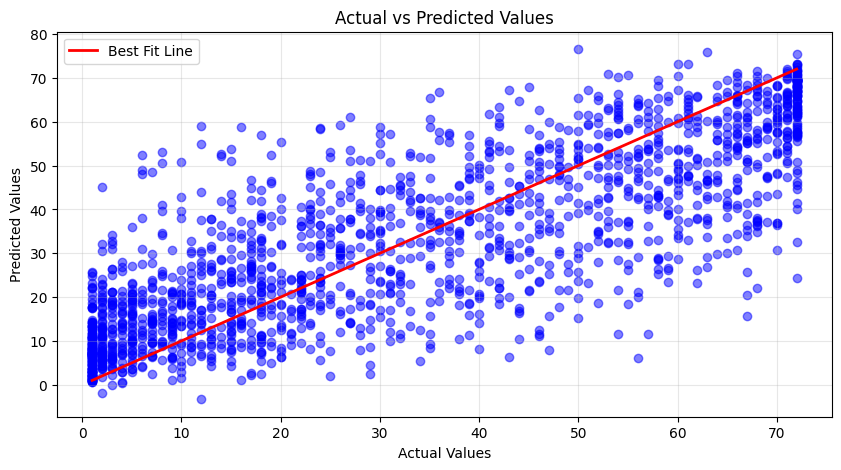

In [104]:
# Plotting of y_test and y_pred

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', lw=2, label='Best Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Residual Plot for final model

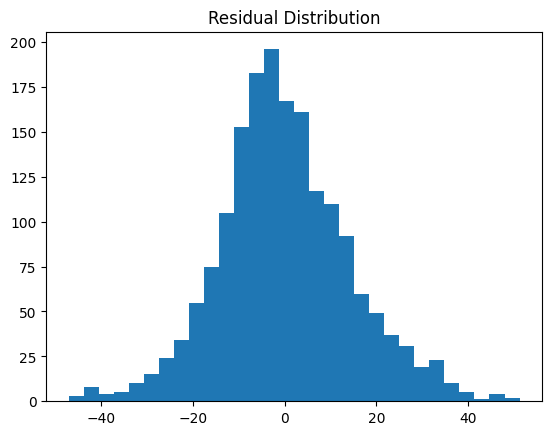

In [105]:
residuals = y_test - y_test_pred
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()

In [ ]:
# Extract the best model from your RandomizedSearchCV
best_xgb_model = xgb_search.best_estimator_

# Get feature names from your preprocessor
feature_names = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

# Get importance values from the XGBoost model
importances = best_xgb_model.named_steps['model'].feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(5)

,Feature,Importance
36,cat__Contract_Month-to-month,0.493401
14,cat__MultipleLines_Yes,0.079833
1,num__ServiceDensity,0.072910
23,cat__OnlineBackup_Yes,0.067735
44,cat__PaymentMethod_Mailed check,0.044392


#### The cat__Contract_Month-to-month s by far the most important feature (0.49) and the ServiceDensity column which was added during feature engineering is the 3rd most important feature

In [ ]:
import joblib

#save the model
joblib.dump(xgb_search.best_estimator_, 'reg_best_model.pkl')

['reg_best_model.pkl']